**Note: This is my updated notebook that includes all my previous work plus my attempt at modelling WITHOUT back-propagation for the HSIC Bottleneck networks. My detailed (unedited) review is at the very bottom of this notebook.**

In [ ]:
import warnings
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
import keras.backend as K
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Conv2D, Flatten, MaxPooling2D, Dropout

from sklearn.metrics import accuracy_score

sns.set()
%matplotlib inline
tf.compat.v1.disable_v2_behavior()
warnings.filterwarnings("ignore")

## User Defined Functions & Classes

In [ ]:
# funtion to calculate the gaussian kernel matrix
def kernel_matrix(x, sigma):
    ndim = K.ndim(x)
    x1 = K.expand_dims(x, 0)
    x2 = K.expand_dims(x, 1)
    axis = tuple(range(2, ndim+1))

    return K.exp(-0.5*K.sum(K.pow(x1-x2, 2), axis=axis) / sigma ** 2)

# function to calculate the HSIC bottleneck
def hsic(Kx, Ky, m):
    Kxy = K.dot(Kx, Ky)
    h = tf.linalg.trace(Kxy) / m ** 2 + K.mean(Kx) * K.mean(Ky) - \
        2 * K.mean(Kxy) / m

    return h * (m / (m-1))**2

# class to train phase the hidden representations (called pre-training phase) using HSIC training paradigm
class HSIC_pre_train(object):
    def __init__(self, model, batch_size, lambda_0, sigma):
        self.batch_size = batch_size
        # initialize the inputs from the model
        input_x = model._feed_inputs[0]
        input_y = model._feed_targets[0]

        # get the gaussian kernel matrices for the inputs
        Kx = kernel_matrix(input_x, sigma)
        Ky = kernel_matrix(input_y, sigma)


        param2grad = {
        }
        trainable_params = []
        total_loss = 0.

        # loop over the layers of the model
        for layer in model.layers:
            # only train the hidden layers of the model
            if layer.name.startswith("hsic"):
                params = layer.trainable_weights

                if not params:
                    continue

                # get the hidden layer representation
                hidden_z = layer.output
                
                # get the gaussian kernel matrix for the hidden layer
                Kz = kernel_matrix(hidden_z, sigma)

                # calculate the loss using the HSIC bottleneck for the hidden layer
                loss = hsic(Kz, Kx, batch_size) - lambda_0 * hsic(Kz, Ky, batch_size)
                total_loss += loss

                trainable_params.extend(params)

                # calculate the gradients
                grads = K.gradients(loss, params)

                for p, g in zip(params, grads):
                    param2grad[p.name] = g
            else:
                # do not train any other layer other than the hidden layers
                layer.trainable = False

        # set the parameters of the hidden layers
        model._collected_trainable_weights = trainable_params

        # set the HSIC loss of the hidden layers
        model.total_loss = total_loss

        # get the optimizer of the model
        optim = model.optimizer

        # function to get the gradients from the calculated losses and parameters
        def get_gradients(loss, params):
            grads = [param2grad[p.name] for p in params]

            if hasattr(self, 'clipnorm') and self.clipnorm > 0:
                norm = K.sqrt(sum([K.sum(K.square(g)) for g in grads]))
                grads = [K.clip_norm(g, self.clipnorm, norm) for g in grads]
                
            if hasattr(self, 'clipvalue') and self.clipvalue > 0:
                grads = [K.clip(g, -self.clipvalue, self.clipvalue) for g in grads]

            return grads

        # calculate and set the gradients for the model optimizer
        optim.get_gradients = get_gradients

        self.model = model

    # class method to reshape input
    def reshape(self, x):
        shape = list(K.int_shape(x))
        shape[0] = self.batch_size

        return K.reshape(x, tuple(shape))

    def __call__(self):
        return self.model

# class to train the output layer of the model
class HSIC_train(object):
    def __init__(self, model):
        # loop over the layers of the model
        for layer in model.layers:
            if layer.name == "output_layer":
                # only train the output_layer                 
                layer.trainable = True
            else:
                # do not train the network
                layer.trainable = False
                
        self.model = model

    def __call__(self):
        return self.model

## Driver Code

### MNIST

In [ ]:
# check device configuration
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
# get the names of the classes
class_names = np.unique(y_train).tolist()

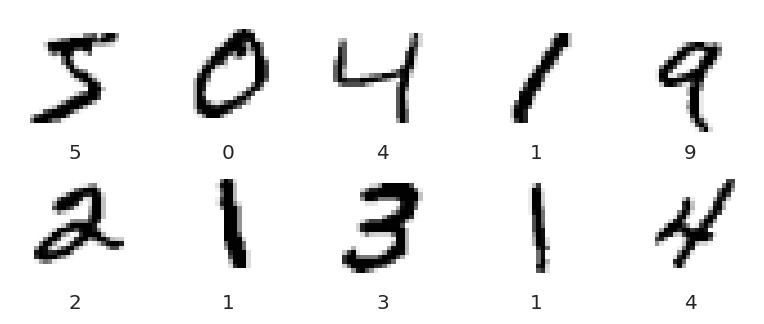

In [ ]:
# display image number 100 in greyscale along with the label
plt.figure(dpi=120, figsize=(8,8))

for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

plt.show()

In [ ]:
# check the shape of images
x_train.shape

(60000, 28, 28)

In [ ]:
# Reshaping the array to 4-dims so that it can work with Keras
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

In [ ]:
# HSIC model building using Keras WITHOUT backpropagation
modelHSIC_mnist = Sequential(name='HSIC Model (MNIST)')
modelHSIC_mnist.add(Flatten(input_shape=input_shape))
modelHSIC_mnist.add(Lambda(lambda x: K.stop_gradient(x), name='stop_backprop'))
modelHSIC_mnist.add(Dense(784, activation='relu', name='hsic_dense1'))
modelHSIC_mnist.add(Dense(256, activation='relu', name='hsic_dense2'))
modelHSIC_mnist.add(Dense(256, activation='relu', name='hsic_dense3'))
modelHSIC_mnist.add(Dense(256, activation='relu', name='hsic_dense4'))
modelHSIC_mnist.add(Dense(256, activation='relu', name='hsic_dense5'))
modelHSIC_mnist.add(Dense(256, activation='relu', name='hsic_dense6'))
modelHSIC_mnist.add(Dense(10, activation='softmax', name='output_layer'))

In [ ]:
# compile the model
modelHSIC_mnist.compile(optimizers.SGD(0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
# implement the HSIC bottleneck algorithm
modelHSIC_mnist = HSIC_pre_train(modelHSIC_mnist, batch_size=128, lambda_0=100, sigma=5)()

In [ ]:
# pre-train the hidden layers of the model
modelHSIC_mnist.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=128)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 8s 166us/sample - loss: -1.0731 - acc: 0.0825 - val_loss: -1.0628 - val_acc: 0.0828
Epoch 2/10
48000/48000 [==============================] - 5s 105us/sample - loss: -1.0731 - acc: 0.0825 - val_loss: -1.0643 - val_acc: 0.0828
Epoch 3/10
48000/48000 [==============================] - 5s 104us/sample - loss: -1.0741 - acc: 0.0825 - val_loss: -1.0655 - val_acc: 0.0828
Epoch 4/10
48000/48000 [==============================] - 5s 104us/sample - loss: -1.0732 - acc: 0.0825 - val_loss: -1.0646 - val_acc: 0.0828
Epoch 5/10
48000/48000 [==============================] - 5s 105us/sample - loss: -1.0746 - acc: 0.0825 - val_loss: -1.0646 - val_acc: 0.0828
Epoch 6/10
48000/48000 [==============================] - 5s 105us/sample - loss: -1.0740 - acc: 0.0825 - val_loss: -1.0656 - val_acc: 0.0828
Epoch 7/10
48000/48000 [==============================] - 5s 104us/sample - loss: -1.0743 - acc: 0

In [ ]:
# freeze the hidden layer gradients of the model and implement post-training
modelHSIC_mnist = HSIC_train(modelHSIC_mnist)()
modelHSIC_mnist.summary()

Model: "HSIC Model (MNIST)"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 stop_backprop (Lambda)      (None, 784)               0         
                                                                 
 hsic_dense1 (Dense)         (None, 784)               615440    
                                                                 
 hsic_dense2 (Dense)         (None, 256)               200960    
                                                                 
 hsic_dense3 (Dense)         (None, 256)               65792     
                                                                 
 hsic_dense4 (Dense)         (None, 256)               65792     
                                                                 
 hsic_dense5 (Dense)         (None, 256)        

In [ ]:
# compile the model
modelHSIC_mnist.compile(optimizers.SGD(0.001), loss="sparse_categorical_crossentropy", metrics=["acc"])

In [ ]:
# train the output layer of the model
modelHSIC_mnist.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=128)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 1s 24us/sample - loss: 1.0424 - acc: 0.7895 - val_loss: 0.4101 - val_acc: 0.8825
Epoch 2/10
48000/48000 [==============================] - 1s 22us/sample - loss: 0.3195 - acc: 0.9056 - val_loss: 0.3087 - val_acc: 0.9113
Epoch 3/10
48000/48000 [==============================] - 1s 22us/sample - loss: 0.2274 - acc: 0.9318 - val_loss: 0.2641 - val_acc: 0.9240
Epoch 4/10
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1800 - acc: 0.9458 - val_loss: 0.2438 - val_acc: 0.9308
Epoch 5/10
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1456 - acc: 0.9569 - val_loss: 0.2289 - val_acc: 0.9352
Epoch 6/10
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1228 - acc: 0.9640 - val_loss: 0.2215 - val_acc: 0.9390
Epoch 7/10
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1038 - acc: 0.9701 - val_loss: 0.

In [ ]:
# use the HSIC trained model to make predictions on the test data
y_pred = np.argmax(modelHSIC_mnist.predict(x_test), axis=1)

In [ ]:
# testing accuracy of the model
accuracy_score(y_pred, y_test).round(3) * 100

94.8

7


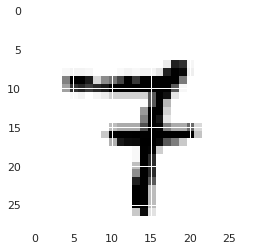

In [ ]:
# make and plot the prediction of the HSIC trained model on a single image of the test data as an example
image_index = 75
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = modelHSIC_mnist.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())

In [ ]:
# Backprop model building using Keras (for comparison)
modelBackprop_mnist = Sequential(name='Backprop Model (MNIST)')
modelBackprop_mnist.add(Flatten(input_shape=input_shape))
modelBackprop_mnist.add(Dense(784, activation='relu', name='mlp_dense1'))
modelBackprop_mnist.add(Dense(256, activation='relu', name='mlp_dense2'))
modelBackprop_mnist.add(Dense(256, activation='relu', name='mlp_dense3'))
modelBackprop_mnist.add(Dense(256, activation='relu', name='mlp_dense4'))
modelBackprop_mnist.add(Dense(256, activation='relu', name='mlp_dense5'))
modelBackprop_mnist.add(Dense(256, activation='relu', name='mlp_dense6'))
modelBackprop_mnist.add(Dense(10, activation='softmax', name='output_layer'))

In [ ]:
# compile the model
modelBackprop_mnist.compile(optimizers.SGD(0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])
modelBackprop_mnist.summary()

Model: "Backprop Model (MNIST)"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 mlp_dense1 (Dense)          (None, 784)               615440    
                                                                 
 mlp_dense2 (Dense)          (None, 256)               200960    
                                                                 
 mlp_dense3 (Dense)          (None, 256)               65792     
                                                                 
 mlp_dense4 (Dense)          (None, 256)               65792     
                                                                 
 mlp_dense5 (Dense)          (None, 256)               65792     
                                                                 
 mlp_dense6 (Dense)          (None, 256)    

In [ ]:
# train the model
modelBackprop_mnist.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=128)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 1s 26us/sample - loss: 1.0575 - acc: 0.7935 - val_loss: 0.4016 - val_acc: 0.8850
Epoch 2/10
48000/48000 [==============================] - 1s 23us/sample - loss: 0.3221 - acc: 0.9058 - val_loss: 0.3145 - val_acc: 0.9071
Epoch 3/10
48000/48000 [==============================] - 1s 23us/sample - loss: 0.2297 - acc: 0.9319 - val_loss: 0.2738 - val_acc: 0.9196
Epoch 4/10
48000/48000 [==============================] - 1s 23us/sample - loss: 0.1800 - acc: 0.9459 - val_loss: 0.2526 - val_acc: 0.9263
Epoch 5/10
48000/48000 [==============================] - 1s 22us/sample - loss: 0.1454 - acc: 0.9564 - val_loss: 0.2342 - val_acc: 0.9321
Epoch 6/10
48000/48000 [==============================] - 1s 22us/sample - loss: 0.1208 - acc: 0.9645 - val_loss: 0.2259 - val_acc: 0.9356
Epoch 7/10
48000/48000 [==============================] - 1s 22us/sample - loss: 0.1023 - acc: 0.9707 - val_loss: 0.

In [ ]:
# use the backprop model to make predictions on the test data
y_pred = np.argmax(modelBackprop_mnist.predict(x_test), axis=1)

In [ ]:
# accuracy of the backprop model
accuracy_score(y_pred, y_test).round(4) * 100

94.34

7


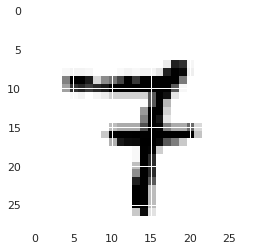

In [ ]:
# make and plot the prediction of the backprop model on a single image of the test data as an example
image_index = 75
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = modelBackprop_mnist.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())

### CIFAR-10

In [ ]:
# load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
# set the label names for the classes
label_names = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 
               4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

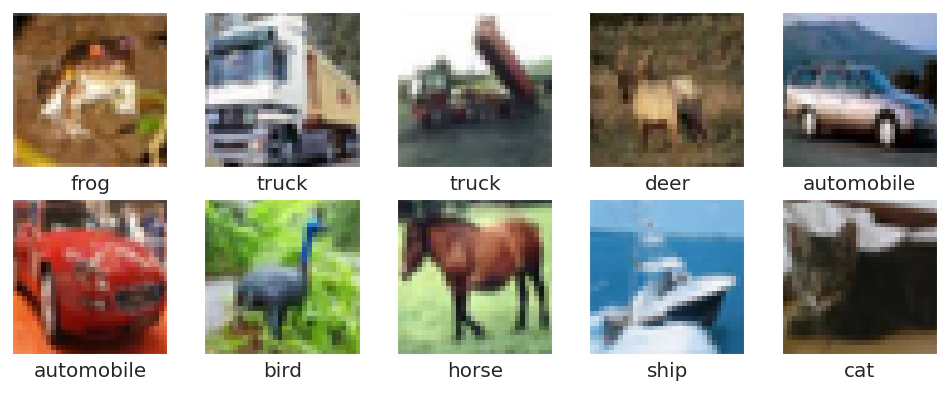

In [ ]:
# dispaly images along with the labels
plt.figure(dpi=120, figsize=(10,10))

for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(label_names[y_train[i][0]])
    
plt.show()

In [ ]:
# check the shape of images
x_train.shape

(50000, 32, 32, 3)

In [ ]:
# set the input shape
input_shape = x_train[0].shape

In [ ]:
# HSIC model building using Keras WITHOUT backpropagation
modelHSIC_cifar = Sequential(name='HSIC Model (CIFAR-10)')

modelHSIC_cifar.add(Input(shape=input_shape))
modelHSIC_cifar.add(Lambda(lambda x: K.stop_gradient(x), name='stop_backprop'))

modelHSIC_cifar.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', name='hsic_conv1'))
modelHSIC_cifar.add(MaxPooling2D(pool_size=(2,2)))
modelHSIC_cifar.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='hsic_conv2'))
modelHSIC_cifar.add(MaxPooling2D(pool_size=(2,2)))

modelHSIC_cifar.add(Flatten())

modelHSIC_cifar.add(Dense(500, activation='relu', name='hsic_dense1'))
modelHSIC_cifar.add(Dense(400, activation='relu', name='hsic_dense2'))
modelHSIC_cifar.add(Dense(300, activation='relu', name='hsic_dense3'))
modelHSIC_cifar.add(Dense(200, activation='relu', name='hsic_dense4'))
modelHSIC_cifar.add(Dense(100, activation='relu', name='hsic_dense5'))

modelHSIC_cifar.add(Dense(10, activation='softmax', name='output_layer'))

In [ ]:
# compile the HSIC model
modelHSIC_cifar.compile(optimizers.SGD(0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
# implement the HSIC bottleneck algorithm
modelHSIC_cifar = HSIC_pre_train(modelHSIC_cifar, batch_size=128, lambda_0=100, sigma=5)()

In [ ]:
# pre-train the hidden layers of the model
modelHSIC_cifar.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=128, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], 
                    workers=256, use_multiprocessing=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 80s 2ms/sample - loss: -1.2401 - acc: 0.1001 - val_loss: -1.2808 - val_acc: 0.0996
Epoch 2/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2386 - acc: 0.1001 - val_loss: -1.2851 - val_acc: 0.0996
Epoch 3/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2406 - acc: 0.1001 - val_loss: -1.2843 - val_acc: 0.0996
Epoch 4/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2402 - acc: 0.1001 - val_loss: -1.2882 - val_acc: 0.0996
Epoch 5/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2390 - acc: 0.1001 - val_loss: -1.2852 - val_acc: 0.0996
Epoch 6/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2396 - acc: 0.1001 - val_loss: -1.2835 - val_acc: 0.0996
Epoch 7/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2383 - acc: 0.1001 -

In [ ]:
# freeze the hidden layer gradients of the model and implement post-training
modelHSIC_cifar = HSIC_train(modelHSIC_cifar)()
modelHSIC_cifar.summary()

Model: "HSIC Model (CIFAR-10)"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 stop_backprop (Lambda)      (None, 32, 32, 3)         0         
                                                                 
 hsic_conv1 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 hsic_conv2 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4096)    

In [ ]:
# compile the model
modelHSIC_cifar.compile(optimizers.SGD(0.001), loss="sparse_categorical_crossentropy", metrics=["acc"])

In [ ]:
# train the output layer of the model
modelHSIC_cifar.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=128, 
                    callbacks=[EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 3s 67us/sample - loss: 2.0846 - acc: 0.2815 - val_loss: 1.7901 - val_acc: 0.3438
Epoch 2/10
40000/40000 [==============================] - 2s 59us/sample - loss: 1.6882 - acc: 0.3894 - val_loss: 1.6613 - val_acc: 0.3996
Epoch 3/10
40000/40000 [==============================] - 2s 59us/sample - loss: 1.5712 - acc: 0.4314 - val_loss: 1.7428 - val_acc: 0.3835
Epoch 4/10
40000/40000 [==============================] - 2s 59us/sample - loss: 1.4950 - acc: 0.4623 - val_loss: 1.4851 - val_acc: 0.4629
Epoch 5/10
40000/40000 [==============================] - 2s 59us/sample - loss: 1.4391 - acc: 0.4848 - val_loss: 1.5466 - val_acc: 0.4497
Epoch 6/10
40000/40000 [==============================] - 2s 59us/sample - loss: 1.3923 - acc: 0.5003 - val_loss: 1.4460 - val_acc: 0.4827
Epoch 7/10
40000/40000 [==============================] - 2s 59us/sample - loss: 1.3529 - acc: 0.5153 - val_loss: 1.

In [ ]:
# make predictions using HSIC trained model on the test data
y_pred = np.argmax(modelHSIC_cifar.predict(x_test), axis=1)

In [ ]:
# accuracy of the HSIC trained model
accuracy_score(y_pred, y_test).round(4) * 100

51.25999999999999

deer


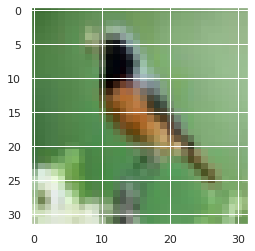

In [ ]:
# make and plot the prediction of the HSIC trained model on a single image of the test data as an example
image_index = 75
plt.imshow(x_test[image_index].reshape(32, 32, 3), cmap='Greys')
pred = modelHSIC_cifar.predict(x_test[image_index].reshape(1, 32, 32, 3))
print(label_names[pred.argmax()])

In [ ]:
# Backprop model building using Keras (for comparison)
modelBackprop_cifar = Sequential(name='Backprop Model (CIFAR-10)')

modelBackprop_cifar.add(Input(shape=input_shape))

modelBackprop_cifar.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', name='mlp_conv1'))
modelBackprop_cifar.add(MaxPooling2D(pool_size=(2,2)))
modelBackprop_cifar.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='mlp_conv2'))
modelBackprop_cifar.add(MaxPooling2D(pool_size=(2,2)))

modelBackprop_cifar.add(Flatten())

modelBackprop_cifar.add(Dense(500, activation='relu', name='mlp_dense1'))
modelBackprop_cifar.add(Dense(400, activation='relu', name='mlp_dense2'))
modelBackprop_cifar.add(Dense(300, activation='relu', name='mlp_dense3'))
modelBackprop_cifar.add(Dense(200, activation='relu', name='mlp_dense4'))
modelBackprop_cifar.add(Dense(100, activation='relu', name='mlp_dense5'))

modelBackprop_cifar.add(Dense(10, activation='softmax', name='output_layer'))

In [ ]:
# compile the model
modelBackprop_cifar.compile(optimizers.SGD(0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])
modelBackprop_cifar.summary()

Model: "Backprop Model (CIFAR-10)"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mlp_conv1 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 mlp_conv2 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4096)              0         
                                                                 
 mlp_dense1 (Dense)          (None, 500) 

In [ ]:
# train the backprop model
modelBackprop_cifar.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=128, 
                    callbacks=[EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 3s 67us/sample - loss: 2.0719 - acc: 0.3051 - val_loss: 1.7362 - val_acc: 0.3746
Epoch 2/10
40000/40000 [==============================] - 2s 59us/sample - loss: 1.6514 - acc: 0.4081 - val_loss: 1.6324 - val_acc: 0.4199
Epoch 3/10
40000/40000 [==============================] - 2s 59us/sample - loss: 1.5303 - acc: 0.4535 - val_loss: 1.5214 - val_acc: 0.4552
Epoch 4/10
40000/40000 [==============================] - 2s 59us/sample - loss: 1.4680 - acc: 0.4757 - val_loss: 1.4467 - val_acc: 0.4845
Epoch 5/10
40000/40000 [==============================] - 2s 59us/sample - loss: 1.4049 - acc: 0.5007 - val_loss: 1.3990 - val_acc: 0.5039
Epoch 6/10
40000/40000 [==============================] - 2s 59us/sample - loss: 1.3583 - acc: 0.5164 - val_loss: 1.4250 - val_acc: 0.4872
Epoch 7/10
40000/40000 [==============================] - 2s 62us/sample - loss: 1.3122 - acc: 0.5330 - val_loss: 1.

In [ ]:
# use the backprop model to make predictions on the test data
y_pred = np.argmax(modelBackprop_cifar.predict(x_test), axis=1)

In [ ]:
# accuracy of the backprop model
accuracy_score(y_pred, y_test).round(3) * 100

54.1

bird


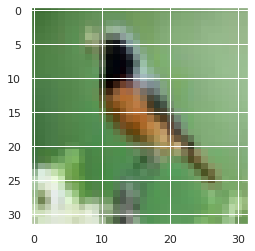

In [ ]:
# make and plot the prediction of the backprop model on a single image of the test data as an example
image_index = 75
plt.imshow(x_test[image_index].reshape(32, 32, 3), cmap='Greys')
pred = modelBackprop_cifar.predict(x_test[image_index].reshape(1, 32, 32, 3))
print(label_names[pred.argmax()])

## Visualisation

### Accuracy vs. Epochs

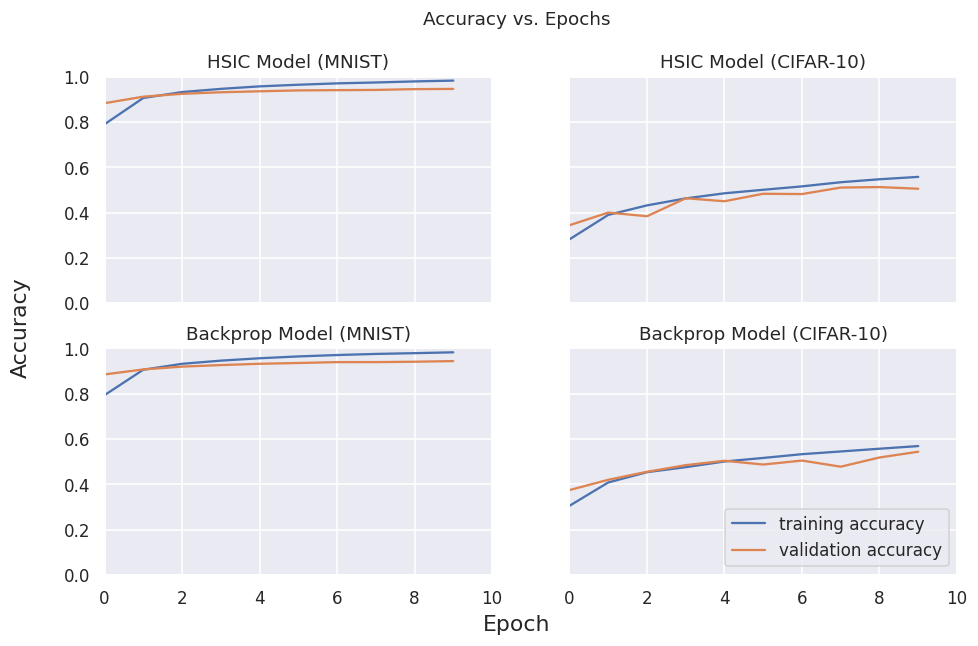

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, dpi=110, figsize=(10, 6))
ax[0, 0].plot(modelHSIC_mnist.history.history['acc'], label='training accuracy')
ax[0, 0].plot(modelHSIC_mnist.history.history['val_acc'], label = 'validation accuracy')
ax[0, 0].set_title('HSIC Model (MNIST)')
ax[1, 0].plot(modelBackprop_mnist.history.history['acc'], label='training accuracy')
ax[1, 0].plot(modelBackprop_mnist.history.history['val_acc'], label = 'validation accuracy')
ax[1, 0].set_title('Backprop Model (MNIST)')
ax[0, 1].plot(modelHSIC_cifar.history.history['acc'], label='training accuracy')
ax[0, 1].plot(modelHSIC_cifar.history.history['val_acc'], label = 'validation accuracy')
ax[0, 1].set_title('HSIC Model (CIFAR-10)')
ax[1, 1].plot(modelBackprop_cifar.history.history['acc'], label='training accuracy')
ax[1, 1].plot(modelBackprop_cifar.history.history['val_acc'], label = 'validation accuracy')
ax[1, 1].set_title('Backprop Model (CIFAR-10)')
fig.suptitle('Accuracy vs. Epochs')
fig.text(0.5, 0.04, 'Epoch', ha='center', fontsize='x-large')
fig.text(0.04, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize='x-large')
plt.xlim([0, 10])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

### Loss vs. Epochs

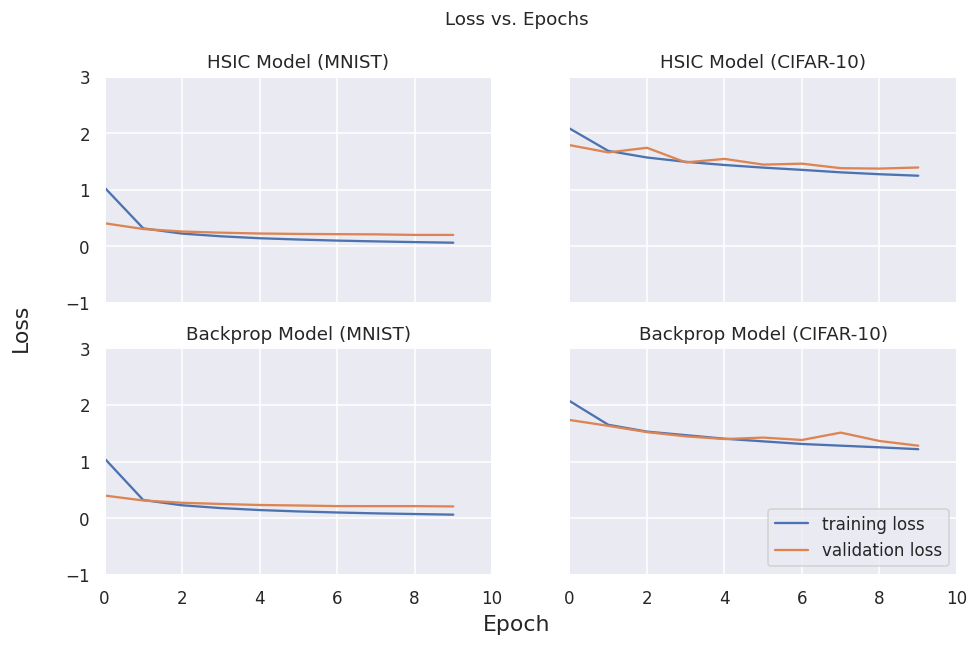

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, dpi=110, figsize=(10, 6))
ax[0, 0].plot(modelHSIC_mnist.history.history['loss'], label='training loss')
ax[0, 0].plot(modelHSIC_mnist.history.history['val_loss'], label = 'validation loss')
ax[0, 0].set_title('HSIC Model (MNIST)')
ax[1, 0].plot(modelBackprop_mnist.history.history['loss'], label='training loss')
ax[1, 0].plot(modelBackprop_mnist.history.history['val_loss'], label = 'validation loss')
ax[1, 0].set_title('Backprop Model (MNIST)')
ax[0, 1].plot(modelHSIC_cifar.history.history['loss'], label='training loss')
ax[0, 1].plot(modelHSIC_cifar.history.history['val_loss'], label = 'validation loss')
ax[0, 1].set_title('HSIC Model (CIFAR-10)')
ax[1, 1].plot(modelBackprop_cifar.history.history['loss'], label='training loss')
ax[1, 1].plot(modelBackprop_cifar.history.history['val_loss'], label = 'validation loss')
ax[1, 1].set_title('Backprop Model (CIFAR-10)')
fig.suptitle('Loss vs. Epochs')
fig.text(0.5, 0.04, 'Epoch', ha='center', fontsize='x-large')
fig.text(0.04, 0.5, 'Loss', va='center', rotation='vertical', fontsize='x-large')
plt.xlim([0, 10])
plt.ylim([-1, 3])
plt.legend(loc='lower right')
plt.show()

## Improvement

In [ ]:
# HSIC model building using Keras (for improvement)
modelHSIC_cifar_improve = Sequential(name='HSIC Model (CIFAR-10)')

modelHSIC_cifar_improve.add(Input(shape=input_shape))
modelHSIC_cifar_improve.add(Lambda(lambda x: K.stop_gradient(x), name='stop_backprop'))

modelHSIC_cifar_improve.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', name='hsic_conv1'))
modelHSIC_cifar_improve.add(MaxPooling2D(pool_size=(2,2)))
modelHSIC_cifar_improve.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='hsic_conv2'))
modelHSIC_cifar_improve.add(MaxPooling2D(pool_size=(2,2)))

modelHSIC_cifar_improve.add(Flatten())

modelHSIC_cifar_improve.add(Dense(500, activation='relu', name='hsic_dense1'))
modelHSIC_cifar_improve.add(Dense(400, activation='relu', name='hsic_dense2'))
modelHSIC_cifar_improve.add(Dense(300, activation='relu', name='hsic_dense3'))
modelHSIC_cifar_improve.add(Dense(200, activation='relu', name='hsic_dense4'))
modelHSIC_cifar_improve.add(Dense(100, activation='relu', name='hsic_dense5'))

# adding droput this time
modelHSIC_cifar_improve.add(Dropout(0.3))

modelHSIC_cifar_improve.add(Dense(10, activation='softmax', name='output_layer'))

In [ ]:
# compile the model
modelHSIC_cifar_improve.compile(optimizers.SGD(0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
# implement the HSIC bottleneck algorithm
modelHSIC_cifar_improve = HSIC_pre_train(modelHSIC_cifar_improve, batch_size=128, lambda_0=100, sigma=5)()

In [ ]:
# pre-train the hidden layers of the model
modelHSIC_cifar_improve.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=128, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], 
                    workers=256, use_multiprocessing=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 75s 2ms/sample - loss: -1.2380 - acc: 0.1028 - val_loss: -1.2821 - val_acc: 0.1006
Epoch 2/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2399 - acc: 0.1015 - val_loss: -1.2838 - val_acc: 0.1006
Epoch 3/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2390 - acc: 0.1033 - val_loss: -1.2819 - val_acc: 0.1006
Epoch 4/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2389 - acc: 0.1033 - val_loss: -1.2866 - val_acc: 0.1006
Epoch 5/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2395 - acc: 0.1041 - val_loss: -1.2813 - val_acc: 0.1006
Epoch 6/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2388 - acc: 0.1032 - val_loss: -1.2842 - val_acc: 0.1006
Epoch 7/10
40000/40000 [==============================] - 74s 2ms/sample - loss: -1.2393 - acc: 0.1025 -

In [ ]:
# train the output layer of the model
modelHSIC_cifar_improve = HSIC_train(modelHSIC_cifar_improve)()
modelHSIC_cifar_improve.summary()

Model: "HSIC Model (CIFAR-10)"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 stop_backprop (Lambda)      (None, 32, 32, 3)         0         
                                                                 
 hsic_conv1 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 hsic_conv2 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 4096)    

In [ ]:
# compile the model
modelHSIC_cifar_improve.compile(optimizers.SGD(0.001), loss="sparse_categorical_crossentropy", metrics=["acc"])

In [ ]:
# train the output layer of the model
modelHSIC_cifar_improve.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=128, 
                    callbacks=[EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 3s 72us/sample - loss: 2.4067 - acc: 0.2107 - val_loss: 1.9169 - val_acc: 0.3178
Epoch 2/10
40000/40000 [==============================] - 2s 61us/sample - loss: 1.9066 - acc: 0.3135 - val_loss: 1.7834 - val_acc: 0.3729
Epoch 3/10
40000/40000 [==============================] - 2s 60us/sample - loss: 1.7776 - acc: 0.3643 - val_loss: 1.6595 - val_acc: 0.4148
Epoch 4/10
40000/40000 [==============================] - 2s 60us/sample - loss: 1.6935 - acc: 0.3950 - val_loss: 1.5709 - val_acc: 0.4466
Epoch 5/10
40000/40000 [==============================] - 2s 60us/sample - loss: 1.6197 - acc: 0.4229 - val_loss: 1.5636 - val_acc: 0.4481
Epoch 6/10
40000/40000 [==============================] - 2s 60us/sample - loss: 1.5674 - acc: 0.4414 - val_loss: 1.5286 - val_acc: 0.4493
Epoch 7/10
40000/40000 [==============================] - 2s 61us/sample - loss: 1.5291 - acc: 0.4528 - val_loss: 1.

In [ ]:
# make predictions using HSIC trained model on the test data
y_pred = np.argmax(modelHSIC_cifar_improve.predict(x_test), axis=1)

In [ ]:
print("Training Accuracy:", accuracy_score(np.argmax(modelHSIC_cifar_improve.predict(x_train), axis=1), y_train).round(4) * 100)
print("Testing Accuracy:", accuracy_score(y_pred, y_test).round(4) * 100)

Training Accuracy: 53.400000000000006
Testing Accuracy: 51.81


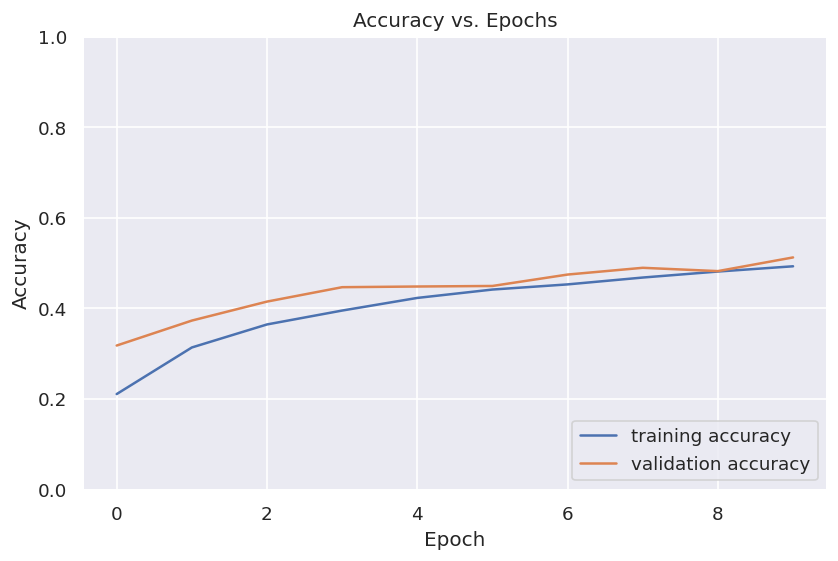

In [ ]:
plt.figure(dpi=120, figsize=(8,5))
plt.plot(modelHSIC_cifar_improve.history.history['acc'], label='training accuracy')
plt.plot(modelHSIC_cifar_improve.history.history['val_acc'], label = 'validation accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## My Review

The authors have managed to come up with an algorithm that is robust and works as promised. The objective function effectively eliminates back-propagation along with its many disadvantages. Personally, I found the algorithm to be absolutely elegant and ingenius, making the hidden representations Z less dependent on X and as much dependent of Y as possible which results in directly computing the gradients, with the help of the HSIC objective function in each hidden layer, without any back-propagation. In terms of accuracy, it certainly trades blows with it's traditional backprop peers, and in some of my experiments (as shown in this notebook) even exceedes them.

However, there are also some shortcomings of this algorithm as mentioned below:- 
1. It is not a user friendly algorithm (yet) and takes some thorough research and experimentation to implement and make it work.
2. It was noticeably slower in terms of training speed and takes more computing resources to train than it's backprop peers.
3. It is heavier with roughly twice the number of parameters.
4. Theoretically, it is supposed to eliminate overfitting. Practically, that wasn't the case.

## Improvement

I wasn't sure what I could do to improve the performance of the model (if only I had a few more days!!!). However, I did notice in my experiments that, at least for shallow-ish networks, the level of overfitting was roughly the same as the backprop model.

To fix this, I simply added a dropout layer in the network and it was able to reduce overfitting by a large amount.

## Future Work

I imagine that these type of networks trained on the HSIC bottleneck based paradigm would be highly advantageous in very deep models, especially in the computer vision based field where models such as ResNet and VGG models are very popular. Moreover, it can (perhaps) also be used in real-time object detection, like the YOLO model.